# Introduction to Differential Privacy 

The goal of this document is to work through building a theoretical understanding of differential privacy while also working through an example dataset and seeing the theory through small examples in code.

In [82]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd


In [3]:
adult = pd.read_csv('adult_with_pii.csv')
adult_data = adult.copy().drop(columns=['Name', 'SSN'])
adult_pii = adult[['Name', 'SSN', 'DOB', 'Zip']]
adult_data.head()

,DOB,Zip,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,9/7/1967,64152,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,6/7/1988,61523,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,8/6/1991,95668,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,4/6/2009,25503,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,9/16/1951,75387,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Defining Differential Privacy
A function $F$ satisfies differential privacy if for all neighboring datasets $x$ and $x'$, and all possible outputs $S$, $$\frac{Pr[F(x) = S]}{Pr[F(x') = S]} \leq e^\epsilon$$

$F$ is called a mechanism.

Two datasets are called neighboring if they differ by one row (or an alternative definition is if they differ by one datapoint).

$F$ is typically a randomized function. The intuition is that the randomness in $F$ allows for any one datapoint $x$ to not have a significant impact on the output of $F$. Equivalently, the output of $F$ cannot be used to infer any one datapoint $x$.

$\epsilon$ is the privacy parameter of this definition. Smaller values of $\epsilon$ make the function $F$ give very similar output for similar inputs which makes it more private. However, this makes the accuracy of $F$ worse. Larger values of $\epsilon$ make the function $F$ give very different output for similar inputs which makes it less private. However, this makes the accuracy of $F$ better. There is a tradeoff between privacy and accuracy.

# The Laplace Mechanism
The Laplace Mechanism is a way to add noise to a function to make it differentially private. It is a simple and intuitive mechanism that is often used in practice. The Laplace Mechanism is defined as follows: Given a function $f(x)$ which returns a number, we can define an $\epsilon-$ differentially private mechanism $F(x)$ as 
$$ F(x) = f(x) + \text{Lap}(\frac{\Delta f}{\epsilon})$$
where $\Delta f$ is the sensitivity of $f$ and $\text{Lap}(S)$ denotes sampling from the Laplace distribution with center $0$ and scale $S$. 

The sensitivity of a function $f$ is defined as the maximum change in the output of $f$ when we change the input of $f$ by one. Formally, the sensitivity of a function $f$ is defined as $$\Delta f = \max_{x,x'} ||f(x) - f(x')||_1$$ where $||\cdot||_1$ denotes the $L_1$ norm.

## Example:
Consider asking the question “How many individuals in the dataset are 40 years old or older?”

This query is a counting query. This means that the query is asking about the number of rows/data points in the dataset that satisfy a certain condition. Counting queries have a sensitivity of 1 because changing 1 row/datapoint in the dataset can only affect 1 of the rows/data points in the dataset that satisfy a certain condition.

14237
14217.063086950571


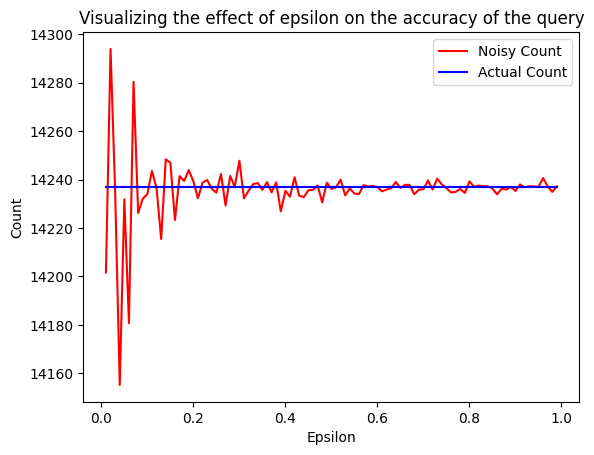

In [30]:
# Gettting an exact answer with no differential privacy
print(adult[adult['Age'] >= 40].shape[0])

# Adding noise with Laplace mechanism to achieve epsilon-differential privacy
epsilon = 0.1
sensitivity = 1
print(adult[adult['Age'] >= 40].shape[0] + np.random.laplace(loc=0, scale=sensitivity/epsilon))

# Visualizing the effect of epsilon on the accuracy of the query
epsilons = np.arange(0.01, 1, 0.01)
sensitivity = 1
actual_count = adult[adult['Age'] >= 40].shape[0]
noisy_counts = []
for epsilon in epsilons:
    noisy_counts.append(actual_count + np.random.laplace(loc=0, scale=sensitivity/epsilon))
plt.plot(epsilons, noisy_counts, label='Noisy Count', color='red')
plt.plot(epsilons, [actual_count] * len(epsilons), label='Actual Count', color='blue')
plt.xlabel('Epsilon')
plt.ylabel('Count')
plt.title('Visualizing the effect of epsilon on the accuracy of the query')
plt.legend()
plt.show()

## Example:
How do we know if the laplace mechanism has added enough noise so that the output can't be used to infer the input?
Consider the following counting query: "How many individuals are named Karrie Trusslove and have an income greater than \$50k?"

In [62]:
# Getting an answer with no differential privacy
karries_row = adult[adult['Name'] == 'Karrie Trusslove']
print(karries_row[karries_row['Target'] == '<=50K'].shape[0]) # 1 is yes, 0 is no

# Adding noise to achieve epsilon-differential privacy 
sensitivity = 1
epsilon = 0.1

karries_row = adult[adult['Name'] == 'Karrie Trusslove']
print(karries_row[karries_row['Target'] == '<=50K'].shape[0] + np.random.laplace(loc=0, scale=sensitivity/epsilon))

1
17.05549098045782


Notice that the above results are too varied to be able to definitely say 0 or 1. This makes it useless to an adversary trying to figure out "How many individuals are named Karrie Trusslove and have an income greater than \$50k?".

# Properties of Differential Privacy

## Sequential Composition
This bounds the total privacy cost of releasing multiple results of differentially private mechanisms on the same input data.
Formally, if $F_1(x)$ satisfies $({\epsilon}_1)-$ differential privacy and $F_2(x)$ satisfies $({\epsilon}_2)-$ differential privacy, then the mechanism $F(x) = (F_1(x), F_2(x))$ satisfies $({\epsilon}_1 + {\epsilon}_2)-$ differential privacy.

Let's visualize this result:

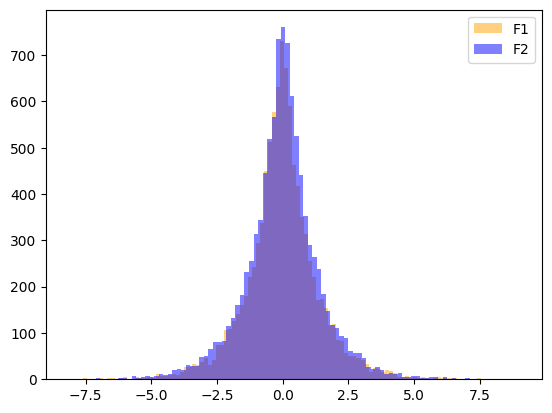

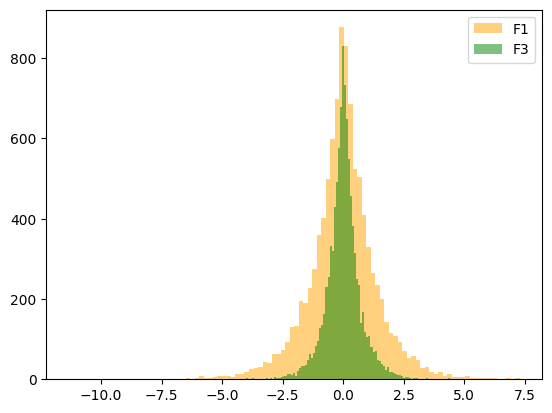

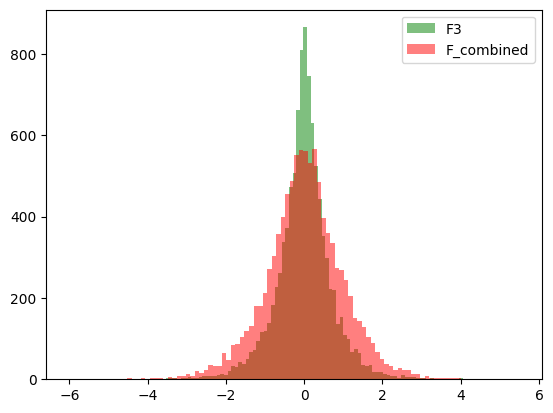

In [69]:
epsilon1 = 1
epsilon2 = 1
epsilon_total = 2
# satisfies 1-differential privacy
def F1():
    return np.random.laplace(loc=0, scale=1/epsilon1)
# satisfies 1-differential privacy
def F2():
    return np.random.laplace(loc=0, scale=1/epsilon2)
# satisfies 2-differential privacy
def F3():
    return np.random.laplace(loc=0, scale=1/epsilon_total)
# satisfies 2-differential privacy, by sequential composition
def F_combined():
    return (F1() + F2()) / 2

# Visualize F1 and F2
plt.hist([F1() for _ in range(10000)], bins=100, alpha=0.5, label='F1', color='orange')
plt.hist([F2() for _ in range(10000)], bins=100, alpha=0.5, label='F2', color='blue')
plt.legend()
plt.show()


# Visualize F1 and F3
plt.hist([F1() for _ in range(10000)], bins=100, alpha=0.5, label='F1', color='orange')
plt.hist([F3() for _ in range(10000)], bins=100, alpha=0.5, label='F3', color='green')
plt.legend()
plt.show()
## Since F3 has a larger epsilon, it is less noisy than F1 and therefore its answers are more accurate and less private
## F2 and F3 is a similar comparison



# Visualize F3 and F_combined
plt.hist([F3() for _ in range(10000)], bins=100, alpha=0.5, label='F3', color='green')
plt.hist([F_combined() for _ in range(10000)], bins=100, alpha=0.5, label='F_combined', color='red')
plt.legend()
plt.show()
## F_combined and F3 should look the same, but remember that F_combined is the sequential composition of F1 and F2 and is an upper bound on the total epsilon.
## Thus, the actual cumulative impact on privacy may be less than the upper bound.

## Parallel Composition
This second property of differential privacy is based on the idea of splitting your dataset into disjoint chunks and running a differentially private mechanism on each chunk separately. Formally, if $F(x)$ satisfies $\epsilon$-differential privacy and we split a dataset $X$ into $k$ disjoint chunks $x_1, x_2, \ldots, x_k$, then the mechanism $F'(X) = (F(x_1), F(x_2), \ldots, F(x_k))$ satisfies $\epsilon$-differential privacy (sequential would give us $k\epsilon$ but we get $\epsilon$ here).

A simple example of this idea is histograms. Histograms make bins counting the number of items in each bin -- the bins are disjoint and the counts are not sensitive. If we add Laplace noise to each bin, then the resulting histogram is differentially private. We can generalize a histogram to have multiple dimensions and this is called a contingency table or cross tabulation. Let's see this idea in action.

In [109]:
np.random.seed(0)
print("Answering the query: How many people are in each grade?")


# Exact answer:
print(adult['Education'].value_counts().sort_index().head(5), '\n')

# DP answer:
epsilon = 1
# This analysis has a total privacy cost of epsilon = 1, even though we release many results!
f = lambda x: x + np.random.laplace(loc=0, scale=1/epsilon) 
s = adult['Education'].value_counts().apply(f) 
print(s.to_frame().sort_index().head(5), '\n')

print("absolute average error:", np.abs(s - adult['Education'].value_counts()).mean())
print("relative average error:", np.abs(s - adult['Education'].value_counts()).mean() / adult['Education'].value_counts().mean(), "\n")



print("\nAnswering the query: How many people of each gender are in each grade?")

# Exact answer:
print(pd.crosstab(adult['Education'], adult['Sex']).sort_index().head(5), '\n')

# DP answer:
ct = pd.crosstab(adult['Education'], adult['Sex'])
f = lambda x: x + np.random.laplace(loc=0, scale=1/epsilon) 
print(ct.applymap(f).sort_index().head(5), '\n')

print("absolute average error:", np.abs(ct.applymap(f) - ct).mean().mean(), "\n")
print("relative average error:", np.abs(ct.applymap(f) - ct).mean().mean() / ct.mean().mean(), "\n")



print("Answering the query: How many people of each gender and race are in each grade?")

# Exact answer:
print(pd.crosstab(adult['Education'], [adult['Sex'], adult['Race']]).sort_index().head(5), '\n')

# DP answer:
ct2 = pd.crosstab(adult['Education'], [adult['Sex'], adult['Race']])
f = lambda x: x + np.random.laplace(loc=0, scale=1/epsilon)
print(ct2.applymap(f).sort_index().head(5), '\n')

print("absolute average error:", np.abs(ct2.applymap(f) - ct2).mean().mean(), "\n")
print("relative average error:", np.abs(ct2.applymap(f) - ct2).mean().mean() / ct2.mean().mean(), "\n")



## As we add more categories, the counts get smaller. 
## Notice that the strength of the noise added is the same, but as we make each category smaller the noise affects the values more.
## This means a more specific query will have more error than a less specific query.
## So, the answer to a more specific question is less accurate and cannot be exploited to learn more about an individual.

Answering the query: How many people are in each grade?
10th        933
11th       1175
12th        433
1st-4th     168
5th-6th     333
Name: Education, dtype: int64 

           Education
10th      934.530377
11th     1175.345012
12th      433.059527
1st-4th   166.048580
5th-6th   334.905107 

absolute average error: 0.7960338295962575
relative average error: 0.00039115940153988264 


Answering the query: How many people of each gender are in each grade?
Sex        Female  Male
Education              
10th          295   638
11th          432   743
12th          144   289
1st-4th        46   122
5th-6th        84   249 

Sex            Female        Male
Education                        
10th       291.791985  637.908214
11th       433.094340  743.147188
12th       144.812637  285.718706
1st-4th     47.347167  122.268234
5th-6th     87.152075  249.253849 

absolute average error: 1.0882372508256615 

relative average error: 0.000958353521436309 

Answering the query: How many people o

## Post-Processing
The third property of differential privacy is the idea that it’s impossible to reverse the privacy protection provided by differential privacy by post-processing the data in some way. Formally, if $F(X)$ satisfies $\epsilon$-differential privacy, then for any function $g$ mapping from the range of $F$ to some arbitrary set, the function $g \circ F(X)$ also satisfies $\epsilon$-differential privacy.

This means we can apply any computations we want to the output of a differentially private query, and the result will still be differentially private. This is a very powerful property, and it’s what allows us to do things like train machine learning models on differentially private data.

# Sensitivity

## Distance
One formal definition of distance $d(x,x')$ in differential privacy is to consider the number of rows which differ between $x$ and $x'$. Formally, this is defined as $$ d(x,x') = |x - x' \cup x' - x| $$

So, in this definition, if $x'$ is constructed by adding/removing a row then $d(x,x') = 1$. If $x'$ is constructed by modifying a single row then $d(x,x') = 2$.

Other definitions of distance in differential privacy exists.

## Sensitivity

Here are some examples for real functions:

The global sensitivity of $f(x)=x$ is 1, since changing $x$ by 1 changes $f(x)$ by 1.

The global sensitivity of $f(x)=x+x$ is 2, since changing $x$ by 1 changes $f(x)$ by 2.

The global sensitivity of $f(x)=5x$ is 5, since changing $x$ by 1 changes $f(x)$ by 5.

The global sensitivity of $f(x)=x*x$ is unbounded, since the change in $f(x)$ depends on the value of $x$.

### Counting Queries
Counting queries always have a sensitivity of 1 because adding a row to the dataset can increase the output of the query by at most 1: either the new row has the desired property, and the count increases by 1, or it does not, and the count stays the same (the count may correspondingly decrease when a row is removed).

Example: “How many people have an educational status equal to or below 10?” or “How many people are named Joe Near?”

### Summation Queries
As a rule of thumb, summation queries have unbounded sensitivity when no lower and upper bounds exist on the value of the attribute being summed. When bounds do exist, the sensitivity of a summation query is equal to the difference between them.

### Average Queries
The easiest way to answer an average query with differential privacy is by making it two queries: a summation query divided by a counting query.

Example: “What is the average age of people with an educational status above 10?”

Answer: adult[adult['Education-Num'] > 10]['Age'].sum() / adult[adult['Education-Num'] > 10]['Age'].shape[0]


## Clipping
The idea of this process is to enforce upper and lower bounds on attributes that have unbounded sensitivity so that we can apply differential privacy. For data that is above or below the bounds, we simply set it to the bound. Then, we can apply differential privacy to the clipped data.

Aggressive clipping can lead to a loss of information and this a loss of accuracy in the final output.

To determine bounds, one should not look at the data because this can reveal information about the data. Instead, one should look at the feature and determine what bounds are reasonable (example: age should be between 0 and 125 or 130). Or, one can incrementally increase the bounds until the output is stable.